# Assignment 1: Part Of Speech Tagging

---

Francesco Ballerini `francesco.ballerini3@studio.unibo.it`

Emmanuele Bollino `emmanuele.bollino@studio.unibo.it`

Tommaso Giannuli `tommaso.giannuli@studio.unibo.it`

Manuel Mariani `manuel.mariani2@studio.unibo.it`

---

A.Y. 2021–22

University of Bologna

# Imports and Dependencies

In [1]:
# Dependency management
# IMPORTANT: for Colab, append --upgrade --no-deps --force-reinstall
%pip install tensorflow==2.7.0 numpy==1.21.4 pandas==1.3.4 requests==2.26.0 gensim==4.1.2 wandb==0.12.7 shortuuid==1.0.8 sentry-sdk==1.5.0 pathtools==0.1.2 sortedcontainers==2.4.0 jinja2==3.0.3 plotly==5.4.0 tenacity==8.0.1 kaleido==0.2.1 -qqq

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Disable tensorflow warnings
import os
import tensorflow as tf
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.autograph.set_verbosity(0)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [3]:
# Text pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Model definition
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Data packages
import numpy as np
import pandas as pd

# System packages
import glob
import os
import logging

# Cloning
from copy import deepcopy

# File management
import requests
import zipfile
import io
from pathlib import Path

# Notebook visualization
from IPython.core.display import display, HTML

# Typing
from typing import List, Dict, Tuple
from sortedcontainers import SortedSet

# For GloVe wrapper
from gensim import downloader as gensloader
from gensim.models.keyedvectors import KeyedVectors

# Plotting
import plotly.express as px
import wandb
from wandb.keras import WandbCallback

# Metrics and utility
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import time

In [4]:
# Set the seeds
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# 1 - Data Pipeline

## 1.1 - Data Loading
First of all, we load the dataset and store it into a dataframe.

In [5]:
DATASET_PATH = './dependency_treebank'  # Change if dataset already present locally
DATASET_URL = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'


def load_dataset(ds_path: str, ds_url: str) -> pd.DataFrame:
    # Check if dataset is already present, otherwise download it
    if not Path(ds_path).exists():
        request_zip = requests.get(ds_url, stream=True)
        zip = zipfile.ZipFile(io.BytesIO(request_zip.content))
        zip.extractall()

    # Load each file into a list
    documents = []
    for file_name in sorted(glob.glob(f"{ds_path}/*.dp")):
        with open(file_name) as f:
            documents.append(f.read())

    # Convert each row of the documents into a list
    raw_df = []
    sentence_idx = 0
    for doc_idx, doc in enumerate(documents):
        rows = doc.split('\n')
        for row in rows:
            cols = row.split('\t')[:2]  # Ignore the last column
            if cols == ['']:
                sentence_idx += 1
            else:
                raw_df.append([doc_idx, sentence_idx, *cols])

    # Finally, convert the nested list into a pandas dataframe
    df = pd.DataFrame(raw_df, columns=['document', 'sentence', 'token', 'tag'])
    return df


dataset = load_dataset(DATASET_PATH, DATASET_URL)
dataset.head()

,document,sentence,token,tag
0,0,0,Pierre,NNP
1,0,0,Vinken,NNP
2,0,0,",",","
3,0,0,61,CD
4,0,0,years,NNS


## 1.2 - GloVe Loading
Then, we load the GloVe embeddings (GloVe-50, to be precise).

In [6]:
EMB_DIM = 50
GLOVE_TYPE = f'glove-wiki-gigaword-{EMB_DIM}'
GLOVE_FILE = f'./glove/glove-wiki-gigaword-{EMB_DIM}.kv'


def load_glove(gl_file: str, gl_type: str) -> KeyedVectors:
    # Load local version
    path = Path(gl_file)
    if path.exists():
        return KeyedVectors.load(gl_file)

    # Otherwise download and store glove
    path.parent.mkdir(parents=True, exist_ok=True)
    glove = gensloader.load(gl_type)
    glove.save(gl_file)
    return glove


glove = load_glove(GLOVE_FILE, GLOVE_TYPE)

## 1.3 - Pre-processing
Our dataset is already relatively clean; however, one point that might be worth considering is how to handle lowercase conversions. Some tokens in our dataset will be intrinsically capitalized (e.g. proper nouns, the personal pronoun "I"), whereas some other will be capitalized only because they follow a period in the sentence they occur in.

One might think of converting a token to lowercase based on its tag (e.g. if a token is a proper noun, keep it capitalized); however, to be fair, this could only be done on the training set, since in a real scenario test-set tags would be unknown.

Anyway, all these considerations hold only if GloVe contains embeddings of capitalized words; if that's not the case, every word we keep as capitalized will be classified as OOV when matched with GloVe, even when their lowercase embedding actually exists.

As it turns out, Glove does not encode capitalized words:


In [7]:
num_capitalized = len(list(filter(lambda w: w[0].isupper(), glove.key_to_index.keys())))

print(f'GloVe-50 encodes {num_capitalized} capitalized words')

GloVe-50 encodes 0 capitalized words


Therefore, we will be forced to convert all tokens to lowercase.

We are also interested to see which "special" tokens are encoded in GloVe, i.e. punctuation, quotation marks, and tokens such as "-LRB-" and "-RRB-", which in our dataset replace "(" and ")", respectively.

As it turns out, GloVe contains every special symbol we care about, except for tokens reserved to brackets:

In [8]:
special_tokens = [
    *',.:;"`$#£!%/?^-()[]{}_', "''", "``", "--", "-LRB-", "-RRB-", "-LSB-", "-RSB-", "-LCB-",
    "-RCB-"
]
for st in special_tokens:
    if st not in glove:
        print(f'GloVe does not contain token {st}')

GloVe does not contain token -LRB-
GloVe does not contain token -RRB-
GloVe does not contain token -LSB-
GloVe does not contain token -RSB-
GloVe does not contain token -LCB-
GloVe does not contain token -RCB-


Based on the previous considerations, we convert all tokens to lowercase and replace "-LRB"-like symbols with the corresponding bracket.

In [9]:
# Convert the brackets
for token, bracket in [('-LRB-', '('), ('-RRB-', ')'), ('-LSB-', '['), ('-RSB-', ']'),
                       ('-LCB-', '{'), ('-RCB-', '}')]:
    dataset.loc[dataset.token == token, 'token'] = bracket

# Convert dataset tokens to lowercase
dataset.loc[:, 'token'] = dataset['token'].str.lower()

## 1.4 - Splitting
After pre-processing the data, we can split the dataset into train, validation and test sets.

In [10]:
TRAIN_DOC_UB = 99
TEST_DOC_LB = 150

ds_train = dataset[dataset['document'].le(TRAIN_DOC_UB)]
ds_val = dataset[dataset['document'].between(TRAIN_DOC_UB, TEST_DOC_LB,
                                             inclusive='neither')].reset_index()
ds_test = dataset[dataset['document'].ge(TEST_DOC_LB)].reset_index()

print_split = lambda df: f"{df.groupby('document').ngroups} documents, {len(df)} tokens"
print(f"""Dataset split: 
    TRAIN: {print_split(ds_train)}
    VALIDATION: {print_split(ds_val)}
    TEST: {print_split(ds_test)}
""")

Dataset split: 
    TRAIN: 100 documents, 47356 tokens
    VALIDATION: 50 documents, 31183 tokens
    TEST: 49 documents, 15545 tokens



## 1.5 - OOV Handling

### 1.5.1 - OOV Analysis
First of all, let us take a look at how many Out-Of-Vocabulary tokens (w.r.t. GloVe) our dataset contains. In order to simulate a real-world scenario, in which test samples are not readily available at training time, we are going to check (and then handle) OOVs *incrementally*; that is, we will consider:
* **OOV1:** training-set tokens which are not found in V1 = GloVe.
* **OOV2:** validation-set tokens which are not found in V2 = `union(`V1, OOV1`)`.
* **OOV3:** test-set tokens which are not found in V3 = `union(`V2, OOV2`)`.

Our final vocabulary will be V4 = `union(`V3, OOV3`)` = `union(`GloVe, OOV1, OOV2, OOV3).

In [11]:
glove_keys = SortedSet(glove.key_to_index.keys())
oov1 = SortedSet(ds_train['token']) - glove_keys
v2 = glove_keys.union(oov1)
oov2 = SortedSet(ds_val['token']) - v2
v3 = v2.union(oov2)
oov3 = SortedSet(ds_test['token']) - v3

print(f'OOV1:  {len(oov1)} tokens')
print(f'OOV2:  {len(oov2)} tokens')
print(f'OOV3:  {len(oov3)} tokens')
l = len(oov1) + len(oov2) + len(oov3)
print(f'Total: {l} tokens ({l / len(set(dataset["token"])) * 100:.2f}% of dataset)')

OOV1:  355 tokens
OOV2:  189 tokens
OOV3:  128 tokens
Total: 672 tokens (6.14% of dataset)


### 1.5.2 - Adding OOVs to GloVe
We can now add OOV tokens to the GloVe vocabulary. Many strategies can be adopted to encode OOVs as vectors:
1. Static embeddings with the same vector for all OOV tokens (e.g. zeros).
2. Random embeddings. 
3. Computing an embedding as some statistic involving neighboring tokens (e.g. their mean).

Two observations can guide us in the choice of an embedding strategy:
* OOV tokens are not negligible (about 6% of the *total* dataset).
* Our GloVe embeddings will not undergo further training, therefore fixed or random embedding values will not be refined during the training process.

For the two reasons above, given an OOV token, we will compute its embedding as the mean of its left and right neighbors across all its occurrences throughout the dataset.


In [12]:
def compute_neighbor_mean(oov_token: str, df: pd.DataFrame, embeddings: KeyedVectors) -> np.ndarray:
    # Find indexes where the oov token appears, and shift them by -1 +1
    indexes = df.index[df['token'] == oov_token].values
    indexes = np.concatenate((indexes - 1, indexes + 1))

    # For each oov word index, look at the left and right until a word with embedding has been found
    neighbor_embeddings = []
    for idx in indexes:
        for direction in (range(idx - 1, -1, -1), range(idx + 1, len(df))):
            for i in direction:
                tok = df['token'].iloc[i]
                if tok not in embeddings:
                    continue
                vector = embeddings[tok]
                neighbor_embeddings.append(vector)
                break

    return np.mean(neighbor_embeddings, axis=0)


def add_oovs(oov_tokens: SortedSet, df: pd.DataFrame, embeddings: KeyedVectors) -> KeyedVectors:
    # Clone the embedding (KeyedVectors does not have a clone method)
    emb_filled = deepcopy(embeddings)

    # Estimate the OOV embeddings
    keys, values = [], []
    for oov in oov_tokens:
        vector = compute_neighbor_mean(oov, df, emb_filled)
        keys.append(oov)
        values.append(vector)
    # Add the estimates to the embedding
    emb_filled.add_vectors(keys, values)
    return emb_filled

In [13]:
# V2 = union(Glove, OOV1)
# where neighbors of OOV1 are taken from the trainig set
embeddings = add_oovs(oov1, ds_train, glove)

# V3 = union(V2, OOV2)
# where neighbors of OOV2 are taken from the validation set
embeddings = add_oovs(oov2, ds_val, embeddings)

# V4 = union(V3, OOV3)
# where neighbors of OOV3 are taken from the test set
embeddings = add_oovs(oov3, ds_test, embeddings)

# Test number of embeddings
print(f'Number of vectors in original GloVe:                  {len(glove)}')
print(f'Number of vectors after incremental addition of OOVs: {len(embeddings)}')

Number of vectors in original GloVe:                  400000
Number of vectors after incremental addition of OOVs: 400672


## 1.6 - Embedding Matrix

In [14]:
# Define the indexes used for word -> index -> embedding
word_index = {k: v + 1 for k, v in embeddings.key_to_index.items()}  # +1 because index 0...
vocab_size = len(embeddings) + 1  # ...will be reserved to padding

# Define the embedding matrix
embedding_matrix = np.zeros(shape=(vocab_size, EMB_DIM))
for word, index in word_index.items():
    embedding_matrix[index] = embeddings[word]

In [15]:
# Quick test
assert np.all(embedding_matrix[embeddings.key_to_index['cat'] + 1] == embeddings['cat'])

## 1.7 - Data Conversion

The input data of our model could be either whole documents or single sentences contained in those documents; we will choose sentences as input data.

Tokens in each sentence will be converted to integer sequences and later fed into a static `Embedding` layer storing the matrix of Glove encodings + OOVs, which will provide the input to our model.

The corresponding tags—i.e. the output of our model—will be instead one-hot encoded. The rationale behind this choice is that tags are purely categorical data, hence encoding them as integer sequences would inject a notion of ordering into the model, which however is not reflected in the original data.

In [16]:
# Utility function
flatten_1d = lambda nested_list: [li[0] for li in nested_list]

# Convert tokens into sequences (their vocabulary indexes)
tokenizer = Tokenizer(filters='')
tokenizer.word_index = word_index
token_indexes = tokenizer.texts_to_sequences_generator(dataset['token'].array)
token_indexes = flatten_1d(token_indexes)

# Convert tags into sequences
# (as an intermediate step before one-hot encoding them)
tag_to_int = {k: v + 1 for v, k in enumerate(dataset['tag'].unique())}
num_tags = len(tag_to_int) + 1
tokenizer = Tokenizer(filters='', lower=False)
tokenizer.word_index = tag_to_int
tag_indexes = tokenizer.texts_to_sequences_generator(dataset['tag'].array)
tag_indexes = flatten_1d(tag_indexes)

# Augment dataset with new data
dataset['token_index'] = token_indexes
dataset['tag_index'] = tag_indexes

# Group dataset by 'sentence', aggregating remaining data into lists
ds_sentences = dataset.groupby(['document', 'sentence']).agg(list)
ds_sentences.head()

token  \
document sentence                                                      
0        0         [pierre, vinken, ,, 61, years, old, ,, will, j...   
         1         [mr., vinken, is, chairman, of, elsevier, n.v....   
1        2         [rudolph, agnew, ,, 55, years, old, and, forme...   
2        3         [a, form, of, asbestos, once, used, to, make, ...   
         4         [the, asbestos, fiber, ,, crocidolite, ,, is, ...   

                                                                 tag  \
document sentence                                                      
0        0         [NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...   
         1         [NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...   
1        2         [NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...   
2        3         [DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...   
         4         [DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...   

                                                         token_index  \
document sentence                                                      
0        0         [5030, 400339, 2, 4979, 83, 168, 2, 44, 1430, ...   
         1         [1996, 400339, 15, 664, 4, 43651, 60024, 2, 1,...   
1        2         [9951, 34239, 2, 3069, 83, 168, 6, 158, 664, 4...   
2        3         [8, 684, 4, 14666, 443, 181, 5, 160, 5616, 701...   
         4         [1, 14666, 7677, 2, 400123, 2, 15, 7683, 18184...   

                                                           tag_index  
document sentence                                                     
0        0         [1, 1, 2, 3, 4, 5, 2, 6, 7, 8, 9, 10, 8, 5, 9,...  
         1               [1, 1, 12, 9, 10, 1, 1, 2, 8, 1, 13, 9, 11]  
1        2         [1, 1, 2, 3, 4, 5, 14, 5, 9, 10, 1, 1, 1, 1, 2...  
2        3         [8, 9, 10, 9, 17, 16, 18, 7, 1, 9, 4, 12, 16, ...  
         4         [8, 9, 9, 2, 9, 2, 12, 17, 5, 10, 19, 12, 8, 4...

Let us take a look at the distribution of sentence length in the training + validation set (leaving the test set aside) to determine what is an appropriate padded-sequence size (for batching).

99th percentile of sentence length in training + validation set: 56.0


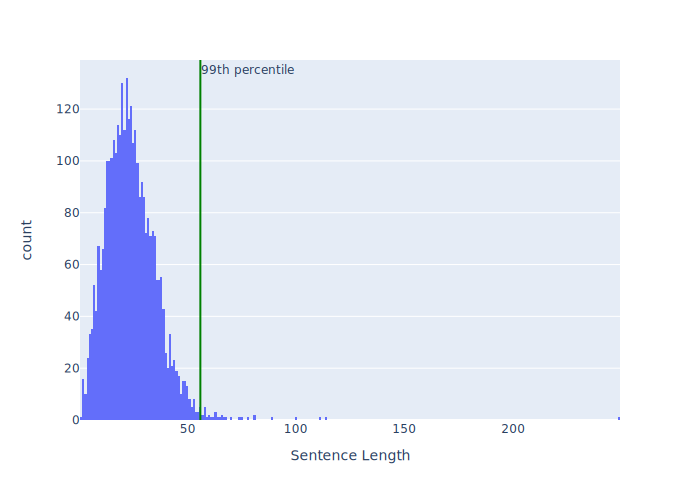

In [17]:
sentences_len = ds_sentences.query(f'document <= {TEST_DOC_LB-1}')['token'].transform(len)
len_quantile = sentences_len.quantile(.99)
print('99th percentile of sentence length in training + validation set:', len_quantile)

fig = px.histogram(sentences_len, labels={'value': 'Sentence Length'})
fig.add_vline(len_quantile, annotation_text="99th percentile", line_color='green')
fig.update_layout(showlegend=False)
fig.show('svg')

The 99th percentile suggests to trim sentences that exceed 56 tokens and pad sentences with fewer tokens, in order to prevent the few outliers from causing sentence encodings to be wastefully long.

In [18]:
pad = lambda x: pad_sequences(x, maxlen=int(len_quantile), padding='pre', truncating='pre')


def get_model_data(df: pd.DataFrame, lb=0, ub=None):
    df = df.query(f'{lb} <= document <= {ub}') if ub else df.query(f'{lb} <= document')
    toks = pad(df['token_index'])
    tags = pad(df['tag_index'])
    # One-hot encode tags
    tags = to_categorical(tags, num_classes=num_tags)
    return toks, tags


# Build the data that will be fed to the model
x_train, y_train = get_model_data(ds_sentences, 0, TRAIN_DOC_UB)
x_val, y_val = get_model_data(ds_sentences, TRAIN_DOC_UB + 1, TEST_DOC_LB - 1)
x_test, y_test = get_model_data(ds_sentences, TEST_DOC_LB)

# Check shapes
print(f"""
X shapes [sentences x tokens]
    x_train.shape = {x_train.shape}
    x_val.shape   = {x_val.shape}
    x_test.shape  = {x_test.shape}

Y shapes [sentences x tags x one-hot-size]
    y_train.shape = {y_train.shape}
    y_val.shape   = {y_val.shape}
    y_test.shape  = {y_test.shape}
""")


X shapes [sentences x tokens]
    x_train.shape = (1963, 56)
    x_val.shape   = (1299, 56)
    x_test.shape  = (652, 56)

Y shapes [sentences x tags x one-hot-size]
    y_train.shape = (1963, 56, 46)
    y_val.shape   = (1299, 56, 46)
    y_test.shape  = (652, 56, 46)



## 1.8 - Class Imbalance Analysis
It is reasonable to expect tags to be non-uniformly distributed throughout our dataset, as some parts of speech are intrinsically more common than others in any natural language.

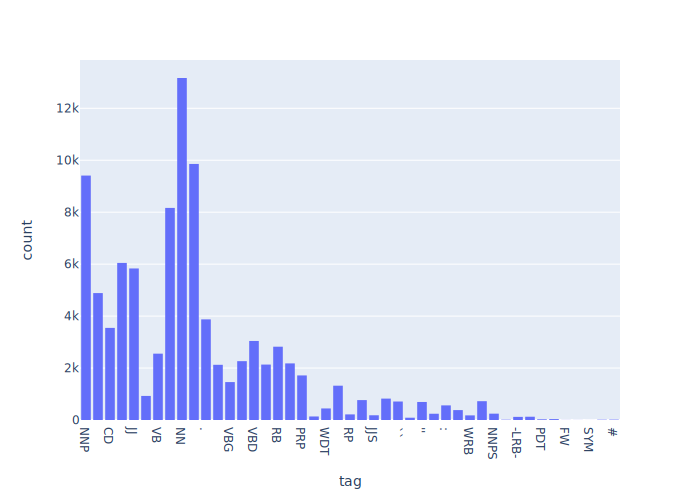

In [19]:
# Plot tag distribution
px.histogram(dataset, x='tag').show('svg')

And indeed, as shown by the histogram above, the tag distribution in out dataset is clearly imbalanced. In order to counteract this phenomenon during training, we are going to assign a (positive) weight to each tag — where such weights get bigger as tags get less common — and then apply those weights to the loss function. In other words, our models are going to get "more rewarded" when they correctly predict an uncommon tag.

In [20]:
def get_sample_weights(y: np.ndarray) -> np.ndarray:
    """Compute class weights for unbalanced label vector y.

    Args:
         y: array of shape (n_samples, sequence_length, one_hot_length)
            storing, for each sample, a sequence of one-hot encoded elements.
    
    Returns:
        Array of shape (n_samples, sequence_length) storing, for each sample,
        a sequence of weights which are inversely proportional to the number 
        of occurrences of the corresponding sequence element in y.
    """
    y_int = np.argmax(y, axis=-1)
    class_weights = compute_class_weight('balanced',
                                         classes=np.unique(y_int.flatten()),
                                         y=y_int.flatten())
    class_weights[0] = 0  # Ignore padding
    int_to_weight = {i: w for i, w in zip(np.unique(y_int), class_weights)}
    int_to_weight_v = np.vectorize(int_to_weight.get)
    return int_to_weight_v(y_int)


train_sample_weights = get_sample_weights(y_train)
val_sample_weights = get_sample_weights(y_val)

# 2 - Model Definition

## 2.1 - Hyperparameters

In [21]:
# Hyperparameters shared by all models
model_hyperparams = dict(
    epochs=500,
    batch_size=128,
    mem_units=32,
    optimizer='adam',
    learning_rate=0.001,
    loss='categorical_crossentropy',
)

# Embedding layer hyperparameters — same for all models
embedding_hyperparams = dict(
    input_dim=vocab_size,
    output_dim=EMB_DIM,
    input_length=x_train.shape[-1],
    weights=[embedding_matrix],
    trainable=False,
)

## 2.2 - Architectures
Four model architectures will be compared, each with different combinations of recurrent and dense layers.

In [22]:
mu = model_hyperparams['mem_units']  # Number of memory units

# Baseline: Bidirectional LSTM + Dense layer
bi_lstm = Sequential([
    Embedding(**embedding_hyperparams),
    Bidirectional(LSTM(mu, return_sequences=True)),
    Dense(num_tags, activation='softmax'),
], 'BiLSTM-Dense')

# Bidirectional GRU + Dense layer
bi_gru = Sequential([
    Embedding(**embedding_hyperparams),
    Bidirectional((GRU(mu, return_sequences=True))),
    Dense(num_tags, activation='softmax'),
], 'BiGRU-Dense')

# Bidirectional LSTM + Bidirectional LSTM + Dense layer
double_bi_lstm = Sequential([
    Embedding(**embedding_hyperparams),
    Bidirectional(LSTM(mu, return_sequences=True)),
    Bidirectional(LSTM(mu, return_sequences=True)),
    Dense(num_tags, activation='softmax'),
], '2xBiLSTM-Dense')

# Bidirectional LSTM + Dense layer + Dense layer
double_dense = Sequential([
    Embedding(**embedding_hyperparams),
    Bidirectional(LSTM(mu, return_sequences=True)),
    Dense(2 * num_tags, activation='relu'),
    Dense(num_tags, activation='softmax'),
], 'BiLSTM-2xDense')

> Since Keras 2.0, `Dense` can handle n-dimensional vectors with n > 2, making `TimeDistributed` layers effectively deprecated.

# 3 - Training
All four models will be trained for the same number of epochs and with the same hyperparameters (when comparable). During training, (either unweighted or weighted) accuracy will be monitored. When training ends, the only stored weigths will be those corresponding to the epoch at which the model reached maximum accuracy on the validation set.

In [23]:
# Set this to true to do an anonymous session
# and reproduce the results without logging into wandb
ANON_SESSION = False
RUN_TRAINING = False

group_name = time.strftime('%Y%m%d-%H%M')
models_history = dict()

# Train and validate all models, logging data in wandb
if RUN_TRAINING:
    trained_runs_ids = []

    for model in [bi_lstm, bi_gru, double_bi_lstm, double_dense]:

        # Initialize wandb with relevant info
        config = model_hyperparams
        config['model-name'] = model.name
        wandb_params = dict(
            project='NLP-POS-Tagging',
            name=model.name,
            reinit=True,
            config=config,
            group=group_name,
        )

        if ANON_SESSION:
            run = wandb.init(anonymous='must', **wandb_params)
        else:
            run = wandb.init(entity='frantoman', **wandb_params)

        # Define a keras callback to save the model when it reaches
        # max weighted validation accuracy
        model_checkpoint = ModelCheckpoint(
            filepath=os.path.join(wandb.run.dir, f'{model.name}.h5'),
            # monitor='val_acc',
            monitor='val_weighted_acc',
            mode='max',
        )

        # Compile the model
        model.compile(
            optimizer=Adam(learning_rate=config['learning_rate']),
            loss='categorical_crossentropy',
            metrics=['acc'],
            weighted_metrics=['acc'],
        )
        print(f'========= TRAINING MODEL: {model.name} {run.id}=========')
        with run:

            # Fit on data and run validation
            history = model.fit(
                x_train,
                y_train,
                epochs=config['epochs'],
                batch_size=config['batch_size'],
                # validation_data=(x_val, y_val),
                validation_data=(x_val, y_val, val_sample_weights),
                sample_weight=train_sample_weights,
                callbacks=[WandbCallback(save_model=False), model_checkpoint],
                verbose=0,
            )

            # Log useful stuff
            h = history.history
            info = dict(
                # best_val_weighted_acc=np.max(h['val_acc']),
                best_val_weighted_acc=np.max(h['val_weighted_acc']),
                # best_weighted_epoch=np.argmax(h['val_acc']) + 1
                best_weighted_epoch=np.argmax(h['val_weighted_acc']) + 1)
            run.log(info)
            trained_runs_ids.append(run.id)
    print(trained_runs_ids)

## 3.1 - Logs and Plots
We logged the training process with [Weights & Biases](https://wandb.ai/site).

Information about the training session with the hyperparameters shown in the previous cells — both with and without class weights — and producing the results discussed in the following sections is available [here](https://wandb.ai/frantoman/NLP-POS-Tagging/reports/Model-Comparison-Training-Validation---VmlldzoxMjk0Nzc2).

# 4 - Evaluation

## 4.1 - Loading Trained Models
Once models have been trained and their "best" weights have been saved, we can load them back to evaluate their performance on unseen data.

In [24]:
acc_ids = ['1vttrcvc', '2zpd7enc', 'llty8pxa', '14qeknoo']
weighted_acc_ids = ['1rfzcy9e', '37z0sxb7', '119d0q0j', '11ucpg2z']


def load_models(ids: List[str]) -> Dict[str, tf.keras.Model]:
    """Load keras models and training info from wandb.

    Args:
        ids: list of wandb run ids.

    Returns:
        models: mapping from model names to keras objects.
    """
    models = dict()
    for id in ids:
        uri = 'frantoman/NLP-POS-Tagging/' + id
        api = wandb.Api()
        run = api.run(uri)

        mn = run.config['model-name']
        print('Downloading', mn)
        run.file(f'{mn}.h5').download(f'./models/', replace=True)

        model = load_model(f'./models/{mn}.h5')
        models[model.name] = model
    return models


models_unweighted = load_models(acc_ids)
print('--------------------------')
models_weighted = load_models(weighted_acc_ids)

--------------------------


## 4.2 - Evaluation Functions
Before moving on to the evaluation, we define the main utility functions that will be needed.

In [25]:
def to_dataframe(x: np.ndarray, y: np.ndarray, p: np.ndarray) -> pd.DataFrame:
    """Converts inputs, ground truths and predictions of a model into a dataframe.
    
    Args:
        x: tensor of shape (n_samples, seq_len) 
           storing input sentences encoded as integer sequences.
        y: tensor of shape (n_samples, seq_len, one_hot_len) 
           storing one-hot encoded ground-truth labels (tags).
        p: tensor of shape (n_samples, seq_len, one_hot_len)
           storing model predictions for input x.

    Returns:
        df: a dataframe storing tokens alongside corresponding
            true and predicted tags.
    """
    # Define a mapping int->token and int->tag
    int_to_tok = {v: k for k, v in word_index.items()}
    int_to_tag = {v: k for k, v in tag_to_int.items()}
    convert_tok = np.vectorize(int_to_tok.get)
    convert_tag = np.vectorize(lambda i: int_to_tag.get(i, 'PAD'))

    # Convert one-hot encodings to integer indexes
    y = np.argmax(y, axis=-1)
    p = np.argmax(p, axis=-1)

    # Convert integer indexes to the corresponding token/tag, skipping padding
    raw_df = dict(token=[], tag_true=[], tag_pred=[])
    for zx, zy, zp in zip(x, y, p):
        pad_mask = zx > 0
        raw_df['token'] += convert_tok(zx[pad_mask]).tolist()
        raw_df['tag_true'] += convert_tag(zy[pad_mask]).tolist()
        raw_df['tag_pred'] += convert_tag(zp[pad_mask]).tolist()

    # Note: the returned df will contain truncated sentences
    df = pd.DataFrame(raw_df)
    df['tag_true'] = df['tag_true'].astype('category')
    df['tag_pred'] = df['tag_pred'].astype('category')

    return df


def remove_punctuation(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """Removes punctuation from dataframe.
    
    Args: 
        df: a dataframe with a column named col_name.

    Returns:
        The same dataframe without rows where column
        col_name contains a punctuation symbol.
    """
    punctuation = "``|''|\,|\.|\:|-LRB-|-RRB-"
    is_punct = df[col_name].str.contains(punctuation)

    return df[~is_punct]


def classif_report(pred: pd.DataFrame) -> pd.DataFrame:
    """Computes main classification metrics and stores them
    into a dataframe.

    Args:
        pred: dataframe returned by to_dataframe().

    Returns:
        df: a dataframe storing classification metrics for each
            tag as well as averages across all tags.
    """
    cr = classification_report(
        pred['tag_true'],
        pred['tag_pred'],
        labels=pred['tag_true'].unique(),
        zero_division=0,
        output_dict=True,
    )
    df = pd.DataFrame(cr).transpose().round(2)

    return df


def evaluate_model(model: tf.keras.Model, x: np.ndarray,
                   y: np.ndarray) -> Tuple[pd.DataFrame, pd.DataFrame, float]:
    """Computes data structures for model evaluation.
    
    Args:
        model: a keras model.
        x: tensor of shape (n_samples, seq_len) 
           storing input sentences encoded as integer sequences.
        y: tensor of shape (n_samples, seq_len, one_hot_len) 
           storing one-hot encoded ground-truth labels (tags).

    Returns:
        pred: dataframe returned by to_dataframe(), 
        without punctuation symbols.
        cr: dataframe returned by classif_report().
        f1m: F1-macro score (contained in cr).
    """
    pred = to_dataframe(x, y, model.predict(x))
    pred = remove_punctuation(pred, 'tag_true')
    cr = classif_report(pred)
    f1m = cr.loc['macro avg', 'f1-score']

    return pred, cr, f1m

## 4.3 - Best Model Selection
We will consider the following two groups of models:
1. Those trained with weighted loss while monitoring weighted accuracy
2. Those trained with unweighted loss while monitoring standard (unweighted) accuracy.

Then, we will choose two models as follows:
* Let `F1` be the F1-macro score computed on the validation set without considering punctuation tags.
* Let `f11` be the highest `F1` achieved by any model in group 1 and `f12` the highest `F1` achieved by any model in group 2.
* Choose group `i` such that `f1i` is the highest.
* Choose the two models with highest `F1` inside group `i`

The chosen two models will finally be tested on the test set and their results compared with the ones on the validation set.

In [26]:
weight_eval = []
for m, t in [
    (models_unweighted, 'Unweighted'),
    (models_weighted, 'Weighted'),
]:
    for model in m.values():
        _, _, f1m = evaluate_model(model, x_val, y_val)
        weight_eval.append(dict(
            model_name=model.name,
            type=t,
            f1_macro_val=f1m,
            model=model,
        ))

weight_eval = pd.DataFrame(weight_eval).sort_values(by='f1_macro_val',
                                                    ascending=False).reset_index(drop=True)
weight_eval.loc[:, weight_eval.columns != 'model']

,model_name,type,f1_macro_val
0,BiLSTM-Dense,Unweighted,0.74
1,2xBiLSTM-Dense,Unweighted,0.73
2,BiGRU-Dense,Weighted,0.73
3,BiLSTM-2xDense,Weighted,0.73
4,BiGRU-Dense,Unweighted,0.71
5,BiLSTM-2xDense,Unweighted,0.71
6,BiLSTM-Dense,Weighted,0.69
7,2xBiLSTM-Dense,Weighted,0.67


Surprisingly, introducing a weighted loss does not seem to play a significant role in the model performance on the validation set as measured by the F1-macro score. Nevertheless, we can apply our previously described selection criterion:

In [27]:
best_m = weight_eval.iloc[0]
select_mask = weight_eval['type'] == best_m['type']
chosen_models = weight_eval[select_mask].iloc[:2]
chosen_models.loc[:, weight_eval.columns != 'model']

,model_name,type,f1_macro_val
0,BiLSTM-Dense,Unweighted,0.74
1,2xBiLSTM-Dense,Unweighted,0.73


## 4.3 - Test Set Performance
We now compare the F1-macro score (without considering punctuation classes) of the two chosen models on the validation and test set.

In [28]:
chosen_models['f1_macro_test'] = [
    evaluate_model(model, x_test, y_test)[2] for model in chosen_models.model.values
]
display(chosen_models.loc[:, chosen_models.columns != 'model'])

,model_name,type,f1_macro_val,f1_macro_test
0,BiLSTM-Dense,Unweighted,0.74,0.80
1,2xBiLSTM-Dense,Unweighted,0.73,0.76


As we can see above, the F1-macro score on the test set is slightly higher than its validation counterpart for both the selected models.

# 5 - Error Analysis
In this section we will compare mistakes made by the two chosen models on the test test with those made on the validation set.

## 5.1 - Most Misclassified Tags

In [29]:
def conf_matrix(df: pd.DataFrame, plot=False) -> Tuple[np.ndarray, np.ndarray]:
    """Computes and plots a confusion matrix.

    Args:
        df: a dataframe with columns 'token', 'tag_true', and 'tag_pred.
        plot: whether to plot the confusion matrix or not.

    Returns:
        conf_m: the confusion matrix (2D).
        tags: array of unique tags in 'tag_true' (1D).
    """
    tags = df['tag_true'].unique()

    conf_m = confusion_matrix(df['tag_true'], df['tag_pred'], labels=tags, normalize='true')
    if plot:
        fig = px.imshow(conf_m,
                        x=tags,
                        y=tags,
                        labels={
                            'x': 'Predicted Tag',
                            'y': 'True Tag',
                            'color': 'Value'
                        })
        fig.update(layout_coloraxis_showscale=False)
        fig.update_layout(width=600, height=600)
        fig.show('svg')

    return conf_m, tags


def get_most_misclass_tags(conf_m: np.ndarray, tags: np.ndarray) -> pd.DataFrame:
    """Detects most misclassified tags in a confusion matrix.

    Args:
        conf_m: a confusion matrix.
        tags: unique labels in the matrix.

    Returns:
        A dataframe storing information about tags whose 
        diagonal value in the matrix is <= 0.5.
    """
    most_misclass = {
        'Tag': [],
        '% Correct Prediction': [],
        'Most Predicted as': [],
        '% Most predicted': []
    }
    bad_toks = tags[conf_m.diagonal() <= 0.5]
    for i, t in enumerate(tags):
        if t in bad_toks:
            most_misclass['Tag'].append(t)
            most_misclass['% Correct Prediction'].append(conf_m.diagonal()[i].round(2))
            most_misclass['Most Predicted as'].append(tags[np.argmax(conf_m[i])])
            most_misclass['% Most predicted'].append(max(conf_m[i]).round(2))
    df = pd.DataFrame(most_misclass).sort_values(by='% Correct Prediction').reset_index(drop='True')

    return df


def display_classif_info(models: pd.DataFrame, x: np.ndarray, y: np.ndarray, plot=False) -> None:
    """Computes a confusion matrix and prints out
    information about the most misclassified tags.

    Args:
        models: dataframe storing information about keras models.
        x: model input tensor.
        y: corresponding labels.
        plot: whether to plot the confusion matrix or not.
    """
    for _, m in models.iterrows():
        pred_df = evaluate_model(m['model'], x, y)[0]
        conf, tags = conf_matrix(pred_df, plot)

        most_mc = get_most_misclass_tags(conf, tags)
        out = most_mc.style.set_caption(m['model'].name)
        out = out.format(precision=2).render()
        display(HTML(out))

### 5.1.1 - Validation Set

In [30]:
display_classif_info(chosen_models, x_val, y_val)

,Tag,% Correct Prediction,Most Predicted as,% Most predicted
0,FW,0.00,NNP,0.50
1,UH,0.00,DT,0.50
2,#,0.07,CD,0.67
3,NNPS,0.10,NNS,0.43
4,PDT,0.21,DT,0.50
5,LS,0.33,CD,0.67


,Tag,% Correct Prediction,Most Predicted as,% Most predicted
0,FW,0.00,NNP,0.50
1,UH,0.00,DT,1.00
2,NNPS,0.14,NNS,0.39
3,PDT,0.14,DT,0.57
4,LS,0.33,NN,0.33
5,#,0.40,#,0.40


### 5.1.2 - Test Set

In [31]:
display_classif_info(chosen_models, x_test, y_test)

,Tag,% Correct Prediction,Most Predicted as,% Most predicted
0,NNPS,0.09,NNS,0.50
1,PDT,0.25,JJ,0.25
2,RBS,0.33,JJS,0.67


,Tag,% Correct Prediction,Most Predicted as,% Most predicted
0,RBS,0.00,JJS,1.00
1,PDT,0.00,JJ,0.50
2,NNPS,0.11,NNS,0.52
3,WP$,0.25,JJ,0.50
4,RBR,0.40,JJR,0.47


### 5.1.3 - Some considerations about the results
The first thing that we can notice is that, as already reflected in the F1 score, the number of heavily misclassified tags (where by *heavily* we mean in more than half of their occurrences) is higher in the validation than in the test set. One reason might be that, although the number of documents is similar in both sets (50 in the validation set VS 49 in the test set), the validation set contains almost double the tokens (i.e. words, since we discarded punctuation) than the test set (31183 VS 15545). As a consequence, the test set might contain a lower number of (or not contain at all) those tags that, due to being quite uncommon in the training set, were not sufficiently grasped by the models. Some examples are `FW` (foreign word), `UH` (interjection), `#` (pound sign), and `LS` (list item marker), which are almost never classified as themselves in the validation set while not even appearing as mistakes in the test set.

Some other more interesting misclassified tags are:
* `NNPS` (plural proper noun), which is mostly classified as `NNS` (plural common noun). The confusion between plural and common nouns is probably due to the lowercase conversion we applied to the dataset in the pre-processing step, which, however, as we already discussed, is unavoidable if we want to deploy GloVe embeddings.
* `PDT` (predeterminer), which tends to be confused with `DT` (determiner) in the validation set (a very subtle mistake) and with `JJ` (adjective) in the test set. It is reasonable to believe that this is due to predeterminers being uncommon tags themselves.
* `RBR`/`RBS` (comparative/superlative adverb), mostly misclassified as `JJR`/`JJS` (comparative/superlative adjective) in the test set. This is quite a forgivable mistakes, especially when we consider that two-syllable adjectives and adverbs are both preceded by "more"/"most".
* `WP$` (possessive wh-pronoun), misclassified as `JJ` (adjective). Again, it is not too surprising to see this uncommon tag (which is assigned to words "whose" and "whom" only) to be mistaken for the much more common adjective category.
 

In order to provide some evidence for our observations above, let us verify that what we assumed to be uncommon tags are actually so:

In [32]:
uncommon_tags = ['FW', 'UH', '#', 'LS', 'PDT', 'WP$']
d = []
for t in uncommon_tags:
    d.append({
        'Tag': t,
        'N. Training': len(ds_train[ds_train['tag'] == t]),
        'N. Validation': len(ds_val[ds_val['tag'] == t]),
        'N. Test': len(ds_test[ds_test['tag'] == t]),
    })

pd.DataFrame(d)

,Tag,N. Training,N. Validation,N. Test
0,FW,2,2,0
1,UH,1,2,0
2,#,1,15,0
3,LS,10,3,0
4,PDT,9,14,4
5,WP$,6,4,4


As we hypothesized, most of the critical tags never even appear in the test set, hence the slightly higher test-set metrics, while also being quite uncommon in the training set, and therefore hard to learn.

In the following subsections, we will make some additional observations by focusing on a single model (the one with the highest F1-macro score among the two already selected ones) and its predictions on the test set alone.

## 5.2 - Class Support and Individual F1 Scores
Let us check whether there is any correlation between F1 scores and the support of classes appearing in the test set.

In [33]:
test_pred, report, _ = evaluate_model(best_m['model'], x_test, y_test)

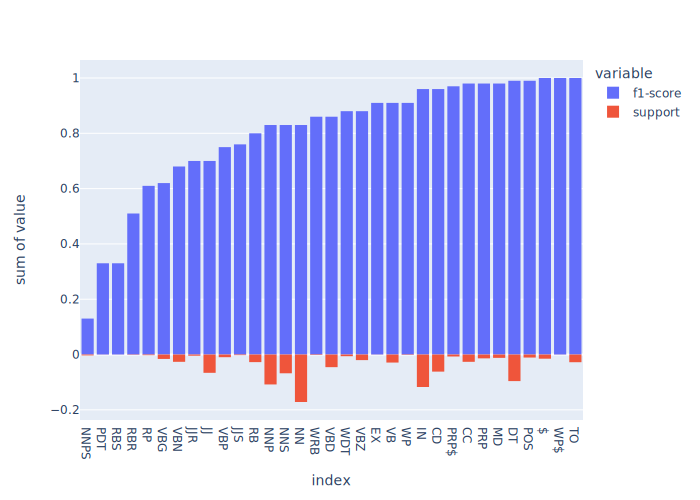

In [34]:
metric = 'f1-score'
class_f1 = report[:-3].sort_values(by=metric)
class_f1['support'] = -class_f1['support'] / sum(class_f1['support'])  # Norm+sign
fig = px.histogram(class_f1, x=class_f1.index, y=[metric, 'support'])
fig.show('svg')

There is no apparent correlation between F1 scores and supports; indeed, classes with high support such as `NN` and `NNP` are not among the best scoring ones. The lowest-scoring class, `NNPS`, was already identified in the previous subsection as being one of the problematic tags.

## 5.3 - OOVs and F1-Macro Score

In [35]:
def get_f1_tok_subset(df, tokens):
    mask = df['token'].apply(lambda t: t in tokens)
    df = df[mask]
    cr = classif_report(df)
    return cr.loc['macro avg', 'f1-score']

print(f"""
F1-macro on test set:
  - Tokens in GloVe: {get_f1_tok_subset(test_pred, glove_keys)}
  - Tokens in OOV1:  {get_f1_tok_subset(test_pred, oov1)}
  - Tokens in OOV2:  {get_f1_tok_subset(test_pred, oov2)}
  - Tokens in OOV3:  {get_f1_tok_subset(test_pred, oov3)}
""")


F1-macro on test set:
  - Tokens in GloVe: 0.8
  - Tokens in OOV1:  0.58
  - Tokens in OOV2:  0.37
  - Tokens in OOV3:  0.43



In [36]:
def df_random_pred(x, y):
    p = np.random.randint(0, y.shape[-1], y.shape)
    return to_dataframe(x, y, p)
rand_pred = df_random_pred(x_test, y_test)

print(f"""
F1-macro on test set, using random predictions:
  - Tokens in GloVe: {get_f1_tok_subset(rand_pred, glove_keys)}
  - Tokens in OOV1:  {get_f1_tok_subset(rand_pred, oov1)}
  - Tokens in OOV2:  {get_f1_tok_subset(rand_pred, oov2)}
  - Tokens in OOV3:  {get_f1_tok_subset(rand_pred, oov3)}
""")


F1-macro on test set, using random predictions:
  - Tokens in GloVe: 0.02
  - Tokens in OOV1:  0.01
  - Tokens in OOV2:  0.07
  - Tokens in OOV3:  0.02



As expected, OOVs appear to be hader to classify than tokens which are part of the original GloVe embeddings, whereas, among OOVs themselves, those belonging to the training set (OOV1) are the highest-scoring ones.

The score on OOVs in the validation and test sets (OOV2 and OOV3) is lower than that on GloVe and OOV1, but still considerably better than a random prediction, indicating that the model has acquired some capacity to generalize and handle unseen tokens.

Surprisingly though, the score on OOV1 tokens is not very high, despite the model being trained on them. This might be caused by OOVs being uncommon throughout the training set or by their embeddings (computed as the mean of the embeddings of their neighboring tokens) being not representative enough, therefore making the corresponding token hard to classify for the model.

## 5.4 - Possible Improvements
Some ideas which could potentially lead to better results with our current model architectures are:

* *Data augmentation*: since the corpus is relatively small, a strategy to generate more training data could be devised, e.g. sentence sub-sampling, token masking, synonym mapping, or embedding noise.

* *Output embeddings*: instead of one-hot encoding tags, map each of them to a vector and perform *similarity learning*. This could result in an embedding space where semantic relationships between tags are reflected in the geometry of the corresponding vectors, possibly allowing models to discriminate between them more effectively.

* *Hyperparametric optimization*, to squeeze every drop out of our models.

Out of all the possible improvements, the one we actually implemented is *sample weighting*, which, given the nature of our data, seemed like the natural choice. However, as we already commented, this solution did not have a visible impact on the metric we adopted to compare our models (F1-macro).

# 6 - [BONUS] Tagging Visualization in a Real-World Application
The following function is conceived to be used — with some refinements — as part of a website or a dedicated software to show the results produced by our model(s). It prints out text in such a way that each token is color-coded by its POS tag; by hovering the pointer on a word, the corresponding tag is shown alongside its meaning. It also allows to compare the predicted tags with the correct ones, as an additional way to inspect the model output.

In [37]:
from collections import defaultdict
# Define a mapping between common POS tags, their meaning and some colors
tag_map = {
    'CC': ('Coordin. Conjunction', '#c18401'),
    'TO': ('“to”', '#c18401'),
    'DT': ('Determiner', '#c18401'),
    'UH': ('Interjection', '#c18401'),
    'EX': ('Existential "there"', '#c18401'),
    'MD': ('Modal can', '#c18401'),
    'LS': ('List item marker', '#c18401'),
    'IN': ('Preposition/sub-conj', '#c18401'),
    'CD': ('Cardinal number', '#282828'),
    'FW': ('Foreign word', '#282828'),
    'NN': ('Noun, singular', '#282828'),
    'NNS': ('Noun, plural', '#282828'),
    'NNP': ('Proper noun, singular', '#282828'),
    'NNPS': ('Proper noun, plural', '#282828'),
    'JJ': ('Adjective', '#50a14f'),
    'JJR': ('Adj. comparative ', '#50a14f'),
    'JJS': ('Adj. superlative ', '#50a14f'),
    'VB': ('Verb, base form', '#e45649'),
    'VBD': ('Verb, past tense ', '#e45649'),
    'VBG': ('Verb, gerund ', '#e45649'),
    'VBN': ('Verb, past particip. ', '#e45649'),
    'VBP': ('Verb, non-3sg pres', '#e45649'),
    'VBZ': ('Verb, 3sg pres ', '#e45649'),
    'WDT': ('Wh-determiner', '#4078f2'),
    'WP': ('Wh-pronoun', '#4078f2'),
    'WP$': (' Possessive wh-', '#4078f2'),
    'WRB': ('Wh-adverb how', '#4078f2'),
    'PDT': ('Predeterminer ', '#4078f2'),
    'POS': ('Possessive ending', '#4078f2'),
    'PP': ('Personal pronoun', '#4078f2'),
    'PP$': (' Possessive pronoun ', '#4078f2'),
    'RB': ('Adverb', '#a626a4'),
    'RBR': ('Adverb, comparative', '#a626a4'),
    'RBS': ('Adverb, superlative', '#a626a4'),
    'RP': ('Particle', '#a626a4'),
}
tag_map = defaultdict(lambda: ('', '#282828'), tag_map)


def display_pos_tagging(tokens: pd.Series,
                        predicted_tags: pd.Series,
                        correct_tags: pd.Series = None,
                        limit=1000):
    # If no correct tags are passed, we ignore the "error highlighting"
    if correct_tags is None:
        correct_tags = predicted_tags

    # Limit the inputs
    tokens = tokens[:limit]
    predicted_tags = predicted_tags[:limit]
    correct_tags = correct_tags[:limit]

    # Iterate through tokens and tags, generating styled HTML based on the tags
    html_sequence = []
    for token, tag, correct in zip(tokens, predicted_tags, correct_tags):
        tag_meaning = tag_map[tag][0]
        err = 'pos-error' if tag != correct else ''
        c = f'/{correct}' if tag != correct else ''
        h = f'<div class="token {tag} {err}">{token} <span class="tag">[{tag}{c}] {tag_meaning}</span></div>'

        if tag == '.':
            h += '</li><li>'
        html_sequence.append(h)
    html_body = '<ol class="pos-visualizer"><li>' + ' '.join(html_sequence) + '</ol>'

    # Generate the style (WARNING: CSS lies ahead)
    html_style = """
	<style>
	.pos-visualizer { padding: 32px; background-color: #FEFEFE; border-left:solid 1px grey;}
	.token { position:relative; display:inline-block; font-size:16px;}
	.token .tag { 
		visibility:hidden; width: 120px; text-align:center; position:absolute;
		width: 160px; background-color: #282828; color: #fff; border-radius: 6px;
		z-index: 1; bottom: 100%; left: 50%; margin-left:-80px; font-size:12px;
	}
	.pos-error { text-decoration: underline solid #F94144;}
	.pos-visualizer li { margin-top:4px }
	.token:hover .tag { visibility:visible }
	"""
    html_style += '\n'.join(
        (f'.{tag} {{color:{tag_map[tag][1]};}}' for tag in predicted_tags.unique()))
    html_style += '</style>'

    # Display HTML in the cell output
    display(HTML(html_style + html_body))

In [38]:
df = to_dataframe(x_test, y_test, best_m['model'].predict(x_test))
display_pos_tagging(df['token'], df['tag_pred'])
# Adding the arg df['tag_true'] enables error highlighting, useful for further analysis